In [1]:
from enum import IntEnum
from typing import List

from gisim.classes.enums import ElementType,ElementalReactionType

In [2]:
import itertools
import matplotlib.pyplot as plt

from pylab import *
mpl.rcParams['font.sans-serif'] = ['SimHei']
mpl.rcParams['axes.unicode_minus'] = False
# 用来数据可视化的 没啥用

ell = {0:"-",1:"冻结",2:"融化",3:"超导",4:"结晶",5:"蒸发",6:"扩散", 7:"感电",8:"超载",9:"绽放",10:"燃烧",11:"激化"}

def imshow(data):
    ax = plt.gca()
    ax.tick_params(top=True, bottom=False,labeltop=True, labelbottom=False)


    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)

    Label =  ["能否附着","冰","水","火","雷","岩","草","风"]
    ax.set_yticks(range(len(Label)))
    ax.set_yticklabels(Label)
    ax.set_xticks(range(len(Label)))
    ax.set_xticklabels(Label)

    for i, j in itertools.product(range(8), range(8)):
        ort = data[i, j]
        if i == 0 and j == 0:
            t = "-"
        elif i == 0 or j == 0:
            t = "能" if ort == 0 else "不能"
        else:
            t = ell[ort]
        text = ax.text(j, i, t,
                    ha="center", va="center", color="k")
    plt.title("元素反应与元素附着",loc="left",pad=30)
    plt.imshow(data,cmap=plt.cm.Blues)
    plt.show()


为了便捷判断元素是否可以参与反应，从而设计了一个8x8的二维矩阵。

第一行和第一列用于标识元素是否可以发生反应。矩阵的对角线没有任何意义。因为同种元素无法发生反应。

将该矩阵称为 RTE（Reaction Table for Element）。

In [3]:
import numpy as np
RTE = np.zeros((8, 8), dtype="int")

RTE

array([[0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0]])

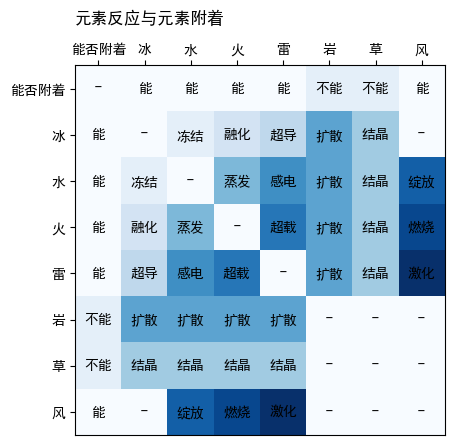

In [4]:
FROZEN_VAL = [ElementType.HYDRO], [ElementType.CRYO], ElementalReactionType.FROZEN
"""冻结反应"""
MELT_VAL = [ElementType.PYRO], [ElementType.CRYO], ElementalReactionType.MELT
"""融化反应"""
SUPERCONDUCT_VAL = [ElementType.ELECTRO], [ElementType.CRYO], ElementalReactionType.SUPERCONDUCT
"""超导反应"""
VAPORIZE_VAL = [ElementType.PYRO], [ElementType.HYDRO], ElementalReactionType.VAPORIZE
"""蒸发反应"""
ELECTROCHARGED_VAL = [ElementType.ELECTRO], [ElementType.HYDRO], ElementalReactionType.ELECTROCHARGED
"""感电反应"""
OVERLOADED_VAL = [ElementType.ELECTRO], [ElementType.PYRO], ElementalReactionType.OVERLOADED
"""超载反应"""
BLOOM_VAL = [ElementType.DENDRO], [ElementType.HYDRO], ElementalReactionType.BLOOM
"""绽放反应"""
BURNING_VAL = [ElementType.DENDRO], [ElementType.PYRO], ElementalReactionType.BURNING
"""燃烧反应"""
QUICKEN_VAL = [ElementType.DENDRO], [ElementType.ELECTRO], ElementalReactionType.QUICKEN
"""激化反应"""
CRYSTALIZE_VAL = [ElementType.GEO], [ElementType.CRYO, ElementType.HYDRO, ElementType.PYRO, ElementType.ELECTRO], ElementalReactionType.CRYSTALIZE
"""结晶反应"""
SWIRL_VAL = [ElementType.ANEMO], [ElementType.CRYO, ElementType.HYDRO, ElementType.PYRO, ElementType.ELECTRO], ElementalReactionType.SWIRL
"""扩散反应"""

ATTACHMENT_GEO_VAL = [ElementType.GEO], [0], 1
"""岩元素不能附着"""
ATTACHMENT_ANEMO_VAL = [ElementType.ANEMO], [0], 1
"""风元素不能附着"""
ELEMENT_REACTION_MAP = [FROZEN_VAL, MELT_VAL, SUPERCONDUCT_VAL, VAPORIZE_VAL, ELECTROCHARGED_VAL, OVERLOADED_VAL, BLOOM_VAL, BURNING_VAL, QUICKEN_VAL, CRYSTALIZE_VAL, SWIRL_VAL, ATTACHMENT_GEO_VAL, ATTACHMENT_ANEMO_VAL]


for row, col, val in ELEMENT_REACTION_MAP:
    RTE[np.ix_(row, col)] = val


# 这个矩阵应该沿着对角线对称
RTE = RTE + RTE.T - np.diag(RTE.diagonal())
imshow(RTE)


In [5]:
def can_attachable(element: ElementType) -> bool:
    """是否为可附着元素 `True` 可附着"""
    attachment = RTE[np.ix_([element], [0])].tolist()
    return attachment[0][0] == 0


def sum_element_reaction(ElementalAttachment: List[ElementType], AddElement: ElementType) -> tuple[ElementalReactionType, int]:
    """计算发生的元素反应"""
    reaction = RTE[np.ix_(ElementalAttachment, [AddElement])]
    multiple_reaction = dict(enumerate(np.nditer(reaction), start=0))
    multiple_reaction = {key: value for key, value in multiple_reaction.items() if value != 0}
    multiple_reaction = sorted(multiple_reaction.items(), key=lambda x: x[1])
    if len(multiple_reaction) == 0:
        return ElementalReactionType.NONE,0
    index, reaction_type = multiple_reaction[0]
    return ElementalReactionType(reaction_type), index


def element_reaction(ElementalAttachment: List[ElementType], AddElement: ElementType) -> tuple[list, ElementalReactionType]:
    if ElementType.GEO in ElementalAttachment or ElementType.ANEMO in ElementalAttachment:
        raise ValueError("There are non attachable elements in the attachment list")
    if AddElement in ElementalAttachment:
        # 挂已经附着的元素没有效果
        return ElementalAttachment, None
    attachable = can_attachable(AddElement)
    if not ElementalAttachment and attachable:
        # 如果角色没有元素附着，且新挂的元素是可附着元素
        ElementalAttachment.append(AddElement)
        return ElementalAttachment, None

    if not ElementalAttachment:
        # 如果角色没有元素附着，且新挂的元素是不可附着元素
        return ElementalAttachment, None
    # 判断元素反应
    reaction_type, index = sum_element_reaction(
        ElementalAttachment, AddElement)
    if reaction_type == ElementalReactionType.NONE:
        if not attachable:
            return ElementalAttachment, None
        ElementalAttachment.append(AddElement)
        return ElementalAttachment, None
    # 发生了元素反应产生效果 获取效果
    ElementalAttachment.pop(index)
    return ElementalAttachment, reaction_type


<img src="https://githubimg.ngworks.cn/GeniusInvokationImg/GameScene/即将发生的元素反应.png_github" width="50%">

冰草水多元素反应。遵循下表规律，越靠左越优先反应。

In [6]:
#  冰 草 水反应
elemental_attachment: List[ElementType] = [ElementType.CRYO, ElementType.DENDRO]
dmg_element_type: ElementType = ElementType.HYDRO

print((["反应的后附着情况"],"触发的反应"))
element_reaction(elemental_attachment, dmg_element_type)

(['反应的后附着情况'], '触发的反应')


([<ElementType.DENDRO: 7>], <ElementalReactionType.FROZEN: 1>)

In [7]:
elemental_attachment: List[ElementType] = [ElementType.DENDRO]
dmg_element_type = ElementType.CRYO

# 不能发生元素反应的
element_reaction(elemental_attachment, dmg_element_type)

([<ElementType.DENDRO: 7>, <ElementType.CRYO: 1>], None)

In [8]:
#重复挂元素的
elemental_attachment: List[ElementType] = [ElementType.DENDRO]
dmg_element_type = ElementType.DENDRO

element_reaction(elemental_attachment, dmg_element_type)

([<ElementType.DENDRO: 7>], None)

In [9]:
#燃烧
elemental_attachment: List[ElementType] = [ElementType.DENDRO]
dmg_element_type = ElementType.PYRO

element_reaction(elemental_attachment, dmg_element_type)

([], <ElementalReactionType.BURNING: 10>)

In [10]:
#草 风不能发生反应 风也不能附着
elemental_attachment: List[ElementType] = [ElementType.DENDRO]
dmg_element_type = ElementType.ANEMO

element_reaction(elemental_attachment, dmg_element_type)

([<ElementType.DENDRO: 7>], None)

In [11]:
# 不能附着的
elemental_attachment: List[ElementType] = []
dmg_element_type = ElementType.ANEMO

element_reaction(elemental_attachment, dmg_element_type)

([], None)

In [12]:
# 多元素扩散
elemental_attachment: List[ElementType] = [ElementType.CRYO, ElementType.DENDRO]
dmg_element_type: ElementType = ElementType.ANEMO


element_reaction(elemental_attachment, dmg_element_type)

([<ElementType.DENDRO: 7>], <ElementalReactionType.SWIRL: 6>)

In [13]:
# 多元素结晶
elemental_attachment: List[ElementType] = [ElementType.CRYO, ElementType.DENDRO]
dmg_element_type: ElementType = ElementType.GEO


element_reaction(elemental_attachment, dmg_element_type)

([<ElementType.DENDRO: 7>], <ElementalReactionType.CRYSTALIZE: 4>)

In [14]:
# 扩散
elemental_attachment: List[ElementType] = [ElementType.PYRO]
dmg_element_type: ElementType = ElementType.ANEMO


element_reaction(elemental_attachment, dmg_element_type)

([], <ElementalReactionType.SWIRL: 6>)

In [15]:
# 结晶
elemental_attachment: List[ElementType] = [ElementType.ELECTRO]
dmg_element_type: ElementType = ElementType.GEO


element_reaction(elemental_attachment, dmg_element_type)

([], <ElementalReactionType.CRYSTALIZE: 4>)

In [16]:
# 输入有问题 比如告诉反应器 某角色附着了不可附着的元素
elemental_attachment: List[ElementType] = [ElementType.GEO]
dmg_element_type: ElementType = ElementType.ANEMO


element_reaction(elemental_attachment, dmg_element_type)

ValueError: There are non attachable elements in the attachment list